##    Target
1.   Improve the accuracy by using Dropout (0.5%)
2.   Batch Normalization after every layer
3.   Add Rotation to training image

##    Results:  

1.   Parameters: 9.47k
2.   Best Train Accuracy: 99.22
3.   Best Test Accuracy: 99.36

##    Analysis (Please refer to Plot and Model Summary):

1.   Good model! Almost there ! Underfitting!! Model has scope to improve !
2.   Need some more parameter tuning to increase accuracy
 


# Import Libraries

In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

Normalize and convert to Tensor.
 
Data is already 28X28, hence no resizing needed


In [11]:
# Train Phase transformations
train_transforms = transforms.Compose([                                       
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)),                                       
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([                                     
                                       transforms.ToTensor(),                                      
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [12]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [13]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Define the Model

In [14]:
import torch.nn.functional as F
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),           
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Display Model parameters

In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1

# Training and Testing

Use **tqdm** progressbar to get visual logs. 


In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # reset grad after each batch
   
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    tqdm._instances.clear()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test the model

In [17]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.10248306393623352 Batch_id=468 Accuracy=86.55: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0975, Accuracy: 9734/10000 (97.34%)

EPOCH: 2


Loss=0.07012645155191422 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.1541380137205124 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.020056147128343582 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.02461843006312847 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.0356348492205143 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.019251305609941483 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.030284198001027107 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.06547319144010544 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.008560587652027607 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.015722109004855156 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.018584800884127617 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.036774132400751114 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.008378338068723679 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.03380897268652916 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]



Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)



# Plot the result

Text(0.5, 1.0, 'Test Accuracy')

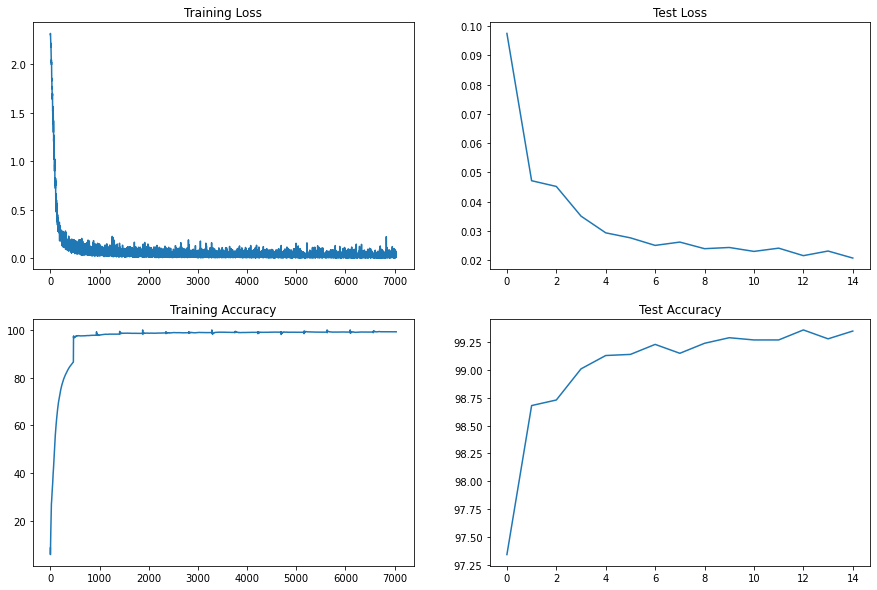

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")